In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from covid19sim.plotting.curve_fitting import GPRFit
import seaborn as sns

%matplotlib inline

In [2]:
def bootstrap(pd_series, num_bootstrap_samples=100):
    """
    Bootstraps from the given series to estimate distribution
    
    Args:
        pd_series (pd.Series):
    
    Returns:
        (list)
    """
    rng = np.random.RandomState(1)
    
    out = []
    for _ in range(num_bootstrap_samples): 
        estimand = pd_series.sample(len(pd_series), replace=True, random_state=rng).to_numpy()
        estimate = np.mean(estimand)
        out.append(estimate)
    return out

In [28]:
BASEPATH = "/Users/mac/Desktop/debug/debug_sensitivity_asymptomatic/CK_27p5_OP/sensitivity_ARx"
n_people=5000
init_fraction_sick=0.004
SCENARIO_STR = f"sensitivity_S_Main_{n_people}_init_{init_fraction_sick}"
MID_STR = "scatter_Ax_0.75_Lx_0.02_Sx_0.20_test_0.001"
dfs = {
    60: pd.read_csv(f"{BASEPATH}/{SCENARIO_STR}_UPTAKE_0.8415/{MID_STR}/normalized_mobility/plots/normalized_mobility/full_extracted_data_AR_60.csv"),
    50: pd.read_csv(f"{BASEPATH}/{SCENARIO_STR}_UPTAKE_0.7170/{MID_STR}/normalized_mobility/plots/normalized_mobility/full_extracted_data_AR_50.csv"),
    40: pd.read_csv(f"{BASEPATH}/{SCENARIO_STR}_UPTAKE_0.5618/{MID_STR}/normalized_mobility/plots/normalized_mobility/full_extracted_data_AR_40.csv"), 
    30: pd.read_csv(f"{BASEPATH}/{SCENARIO_STR}_UPTAKE_0.4215/{MID_STR}/normalized_mobility/plots/normalized_mobility/full_extracted_data_AR_30.csv"),
    20: pd.read_csv(f"{BASEPATH}/{SCENARIO_STR}_UPTAKE_0.2850/{MID_STR}/normalized_mobility/plots/normalized_mobility/full_extracted_data_AR_20.csv"),
}

In [64]:

ARs = sorted(dfs.keys())

NO_TRACING = "post-lockdown-no-tracing"
OTHER_METHODS = ['bdt1', 'heuristicv4'] 
ALL_METHODS = OTHER_METHODS + [NO_TRACING]

# _CONTACT_RANGE_=None # [6 - 0.5 , 6 + 0.5]
_CONTACT_RANGE_= [4, 6]
TARGET_R_FOR_NO_TRACING = 1.2 
MARGIN = 0.75

AR_COLOR_MAP = {
    0: "#34495e",
    20: "mediumvioletred",
    30: "darkorange",
    40: "royalblue",
    50: "#A4C61A",
    60: "#62BB35"
    
}

AR_LABEL_MAP = {
    0: "Post-confinement",
    20: "20%",
    30: "30%",
    40: "40%",
    50: "50%",
    60: "60%"
}
LABELMAP = {
    NO_TRACING: "Post-confinement",
    "bdt1": "BCT",
    "heuristicv4": "Rule-based PCT"
}

Y = 'percentage_infected' # r or percentage_infected
Y_MAP = {
    'r': "$\hat{R}$",
    'percentage_infected': '% infected'
}



In [100]:
distributions = {method:{ar:None} for method in ALL_METHODS for ar in ARs}

# find distribution for no tracing 
no_tracing_df = pd.DataFrame()
for ar in ARs:
    if NO_TRACING in dfs[ar]['method'].unique():
        no_tracing_df = pd.concat([dfs[ar][dfs[ar]['method'] == NO_TRACING], no_tracing_df], axis=0, ignore_index=True)
        break # take from only one set of runs

# find a stable point 
if _CONTACT_RANGE_ is None:
    x = no_tracing_df['effective_contacts'].to_numpy()
    y = no_tracing_df['r'].to_numpy()
    fitted_fn = GPRFit().fit(x, y)
    stable_point = fitted_fn.find_x_for_y(TARGET_R_FOR_NO_TRACING).item()
    CONTACT_RANGE = [stable_point - MARGIN, stable_point + MARGIN]
else:
    CONTACT_RANGE = _CONTACT_RANGE_

n_samples = no_tracing_df[no_tracing_df['effective_contacts'].between(*CONTACT_RANGE)].shape[0]
mu = no_tracing_df[no_tracing_df['effective_contacts'].between(*CONTACT_RANGE)]['effective_contacts'].mean()
std = no_tracing_df[no_tracing_df['effective_contacts'].between(*CONTACT_RANGE)]['effective_contacts'].std()
print(f"{NO_TRACING} #samples:{n_samples}, Mean contacts: {mu} +- {std}")
no_tracing_y_means = bootstrap(no_tracing_df[no_tracing_df['effective_contacts'].between(*CONTACT_RANGE)][Y])
for ar in ARs:
    distributions[NO_TRACING][ar] = no_tracing_y_means
    

# find it for all other adoption rates
# dfo = {method:{ar:None} for method in ALL_METHODS for ar in ARs}
for ar in ARs:
    df = dfs[ar]
    df = df[df["effective_contacts"].between(*CONTACT_RANGE)]
    for method in OTHER_METHODS:
        mu = df[df['method'] == method]['effective_contacts'].mean()
        std = df[df['method'] == method]['effective_contacts'].std() 
        print(f"AR: {ar}% method: {method} #samples:{sum(df['method'] == method)}, Mean contacts: {mu} +- {std}")
#         distributions[method][ar] = bootstrap(df[df['method'] == method][Y])
#         distributions[method][ar] =  df[df['method'] == method][Y]
        num = np.array(bootstrap(df[df['method'] == method][Y]))
        denom = np.array(bootstrap(df[df['method'] == method]['effective_contacts']))
                        
        distributions[method][ar] = list(num/denom)
#         distributions[method][ar] = df[df['method'] == method][Y] / df[df['method'] == method]['effective_contacts']
#         df[df['method'] == method]['effective_contacts'].mean()
#         dfo[method][ar] = df[df['method'] == method]['effective_contacts']
        ratios = df[df['method'] == method][Y] / df[df['method'] == method]['effective_contacts']
        print(f"mean ratio - :{ratios.mean()} ({ratios.std()})")


post-lockdown-no-tracing #samples:100, Mean contacts: 5.721779564623704 +- 1.5303507705360238
AR: 20% method: bdt1 #samples:100, Mean contacts: 5.6557549316766424 +- 1.4780258157377542
mean ratio - :2.4392943045792292 (1.5658187279968716)
AR: 20% method: heuristicv4 #samples:0, Mean contacts: nan +- nan
mean ratio - :nan (nan)
AR: 30% method: bdt1 #samples:100, Mean contacts: 5.5564019741857615 +- 1.4354959919529668
mean ratio - :2.2257910824417078 (1.484108629766257)
AR: 30% method: heuristicv4 #samples:0, Mean contacts: nan +- nan
mean ratio - :nan (nan)
AR: 40% method: bdt1 #samples:100, Mean contacts: 5.385102930227089 +- 1.3361319625972938
mean ratio - :2.2045354719998724 (1.4338778136246992)
AR: 40% method: heuristicv4 #samples:0, Mean contacts: nan +- nan
mean ratio - :nan (nan)
AR: 50% method: bdt1 #samples:100, Mean contacts: 5.3529786880872 +- 1.3502794035278447
mean ratio - :1.4861929294729506 (0.8740817701989353)
AR: 50% method: heuristicv4 #samples:0, Mean contacts: nan +-

In [62]:
df['adoption'].unique()

array(['Post-confinement', '20%', '30%', '40%', '50%', '60%'],
      dtype=object)

In [81]:
df['contacts'].shape

(700,)

IndexError: list index out of range

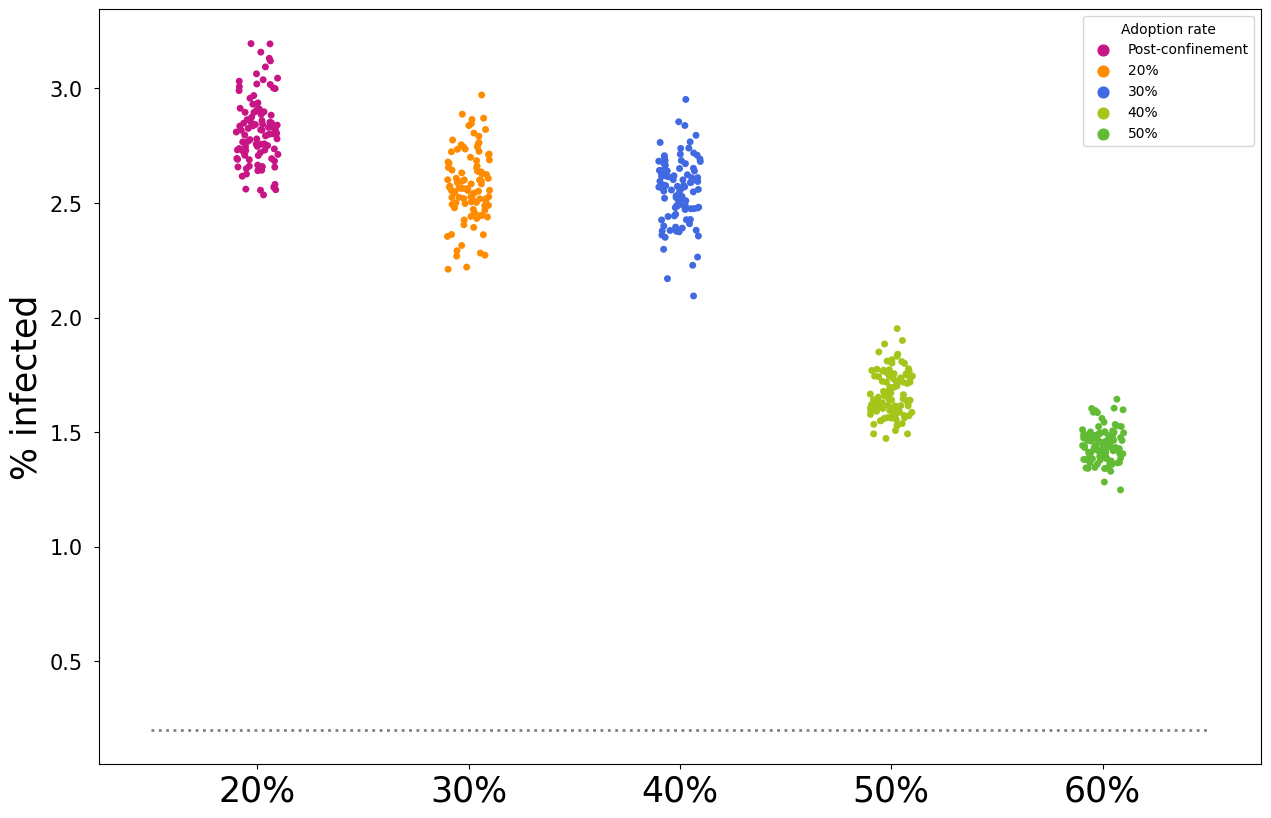

In [101]:
FONT_SIZE = 25
LEGEND_FONTSIZE=12
TICKSIZE=15


df = pd.DataFrame([], columns=['method', Y, 'adoption'])
for method in OTHER_METHODS:
    # add a placeholder for no tracing in each method
    tmp_df = pd.DataFrame() 
    tmp_df[Y] = distributions[NO_TRACING][20] 
    tmp_df['method'] = LABELMAP[method]
    tmp_df['adoption'] = AR_LABEL_MAP[0]
#     tmp_df['contacts'] = dfo[LABELMAP[method]][20]
    df = pd.concat([df, tmp_df], axis=0, ignore_index=True)
    
    for ar in ARs:
        tmp_df = pd.DataFrame() 
        tmp_df[Y] = distributions[method][ar]
        tmp_df['method'] = LABELMAP[method]
        tmp_df['adoption'] = AR_LABEL_MAP[ar]
#         tmp_df['contacts'] = dfo[method][ar]
        df = pd.concat([df, tmp_df], axis=0, ignore_index=True)

plt.figure(figsize=(15, 10), dpi=100)
# ax = sns.violinplot(x="method", y=Y, hue="adoption", data=df, 
#                         inner="quartiles", cut=2, palette={AR_LABEL_MAP[ar]:AR_COLOR_MAP[ar] for ar in [0] + ARs})

ax = sns.stripplot(x="adoption", y=Y, hue="adoption", data=df[ df['adoption']!= 'Post-confinement'], 
                  palette={AR_LABEL_MAP[ar]:AR_COLOR_MAP[ar] for ar in [0] + ARs})


ax.set_xlabel("", fontsize=FONT_SIZE)
ax.set_ylabel(Y_MAP[Y], fontsize=FONT_SIZE)
# ax.set_ylim((0.70, 1.50))
# ax.set_yticks(np.linspace(0.70, 1.50, 8)[1:-1])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=FONT_SIZE)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(TICKSIZE)
    tick.set_pad(8.)


# ref line
if Y == "r":
    ax.plot(ax.get_xlim(),  [1, 1],  linestyle=":", color="gray", linewidth=2)
if Y == "percentage_infected":
    ax.plot(ax.get_xlim(),  [0.2, 0.2],  linestyle=":", color="gray", linewidth=2)
    
# legend
L = ax.legend()
L.set_title("Adoption rate")
L.get_texts()[0].set_text(AR_LABEL_MAP[0])
for i, ar in enumerate(ARs):
    L.get_texts()[i+1].set_text(AR_LABEL_MAP[ar])

_ = plt.setp(L.get_texts(), fontsize=15)
_ = plt.setp(L.get_title(), fontsize=15)

filename = f"{BASEPATH}/violin_sticks_epi_{Y}_raw"
filename += f"_C_{CONTACT_RANGE[0]:.2f}-{CONTACT_RANGE[1]: .2f}" if _CONTACT_RANGE_ is not None else ""
filename = filename.replace(".", "_") # to allow decimals in contact range string
plt.savefig(f"{filename}.png", bbox_inches="tight", pad_inches=0.1)


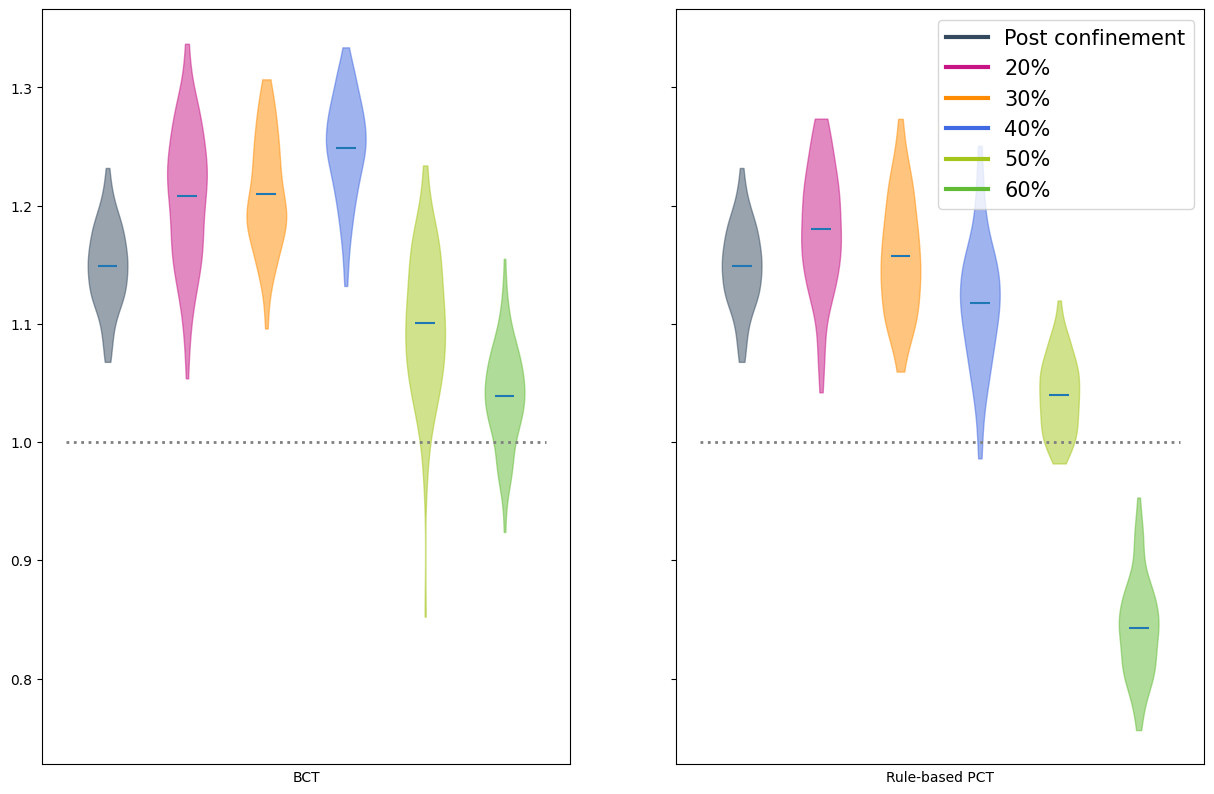

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=len(OTHER_METHODS), figsize=(15,10), dpi=100, sharey=True)


for i, method in enumerate(OTHER_METHODS):
    ax = axs[i]
    r = [distributions[NO_TRACING][20]] + [distributions[method][ar] for ar in ARs]
    parts = ax.violinplot(r, showmeans=True, showextrema=False)
    for j, pc in enumerate(parts['bodies']):
        if j == 0:
            color = AR_COLOR_MAP[0]
        else:
            color = AR_COLOR_MAP[ARs[j-1]]
            
        pc.set_color(color)
        pc.set_alpha(0.5)
        
    ax.plot(ax.get_xlim(),  [1, 1],  linestyle=":", color="gray", linewidth=2)
    ax.set_xticks([])
    ax.set_xlabel(LABELMAP[method])

# legends
legends = [Line2D([0, 1], [0, 0], color=AR_COLOR_MAP[0], linestyle="-", label=AR_LABEL_MAP[0], linewidth=3)]
for ar in ARs:
    method_label = AR_LABEL_MAP[ar]
    color = AR_COLOR_MAP[ar]
    legends.append(Line2D([0, 1], [0, 0], color=color, linestyle="-", label=method_label, linewidth=3))

lgd = axs[-1].legend(handles=legends, ncol=1, fontsize=15, loc="upper right")
